In [94]:
import numpy as np
import networkx as nx
import node2vec.src.node2vec as node2vec
from gensim.models import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn import metrics, model_selection, pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import copy

ImportError: cannot import name 'roc_auc_scorer' from 'sklearn.metrics' (/home/jin/anaconda3/envs/cs591s1/lib/python3.7/site-packages/sklearn/metrics/__init__.py)

In [2]:
class Args:
    pass
args = Args()
args.weighted = False
args.input = '../modi_edgelist.csv'
args.output = '../modi_edgelist.emb'
args.directed = False
args.dimensions = 128
args.window_size = 10
args.workers = 8
args.iter = 1
args.p = 1
args.q = 1
args.num_walks = 10
args.walk_length = 80

In [3]:
# get edge list
def get_edge_list_from_nsblR(edge_list_path, majority_applied='super_majority'):
    df = pd.read_csv(edge_list_path)
    df_filtered = df[df[majority_applied] == 1]
    edge_list = df_filtered[['x', 'y']]
    return edge_list

In [4]:
def read_graph(edge_list_path):
    '''
    Reads the input network in networkx.
    '''
    df_edge_list = get_edge_list_from_nsblR(edge_list_path, 'absolute_majority')
    if args.weighted:
        G = nx.from_pandas_edgelist(df_edge_list, source='x', target='y', create_using=nx.Graph())
    else:
        G = nx.from_pandas_edgelist(df_edge_list, source='x', target='y', create_using=nx.Graph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1

    if not args.directed:
        G = G.to_undirected()

    return G

def learn_embeddings(walks):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [list(map(str, walk)) for walk in walks]
    model = Word2Vec(walks, size=args.dimensions, window=args.window_size, min_count=0, sg=1, workers=args.workers, iter=args.iter)
    model.wv.save_word2vec_format(args.output)
    return model

In [62]:
# Pipeline for representational learning for all nodes in a graph.

nx_G = read_graph(args.input)
G = node2vec.Graph(nx_G, args.directed, args.p, args.q)
G.preprocess_transition_probs()
walks = G.simulate_walks(args.num_walks, args.walk_length)
model = learn_embeddings(walks)

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


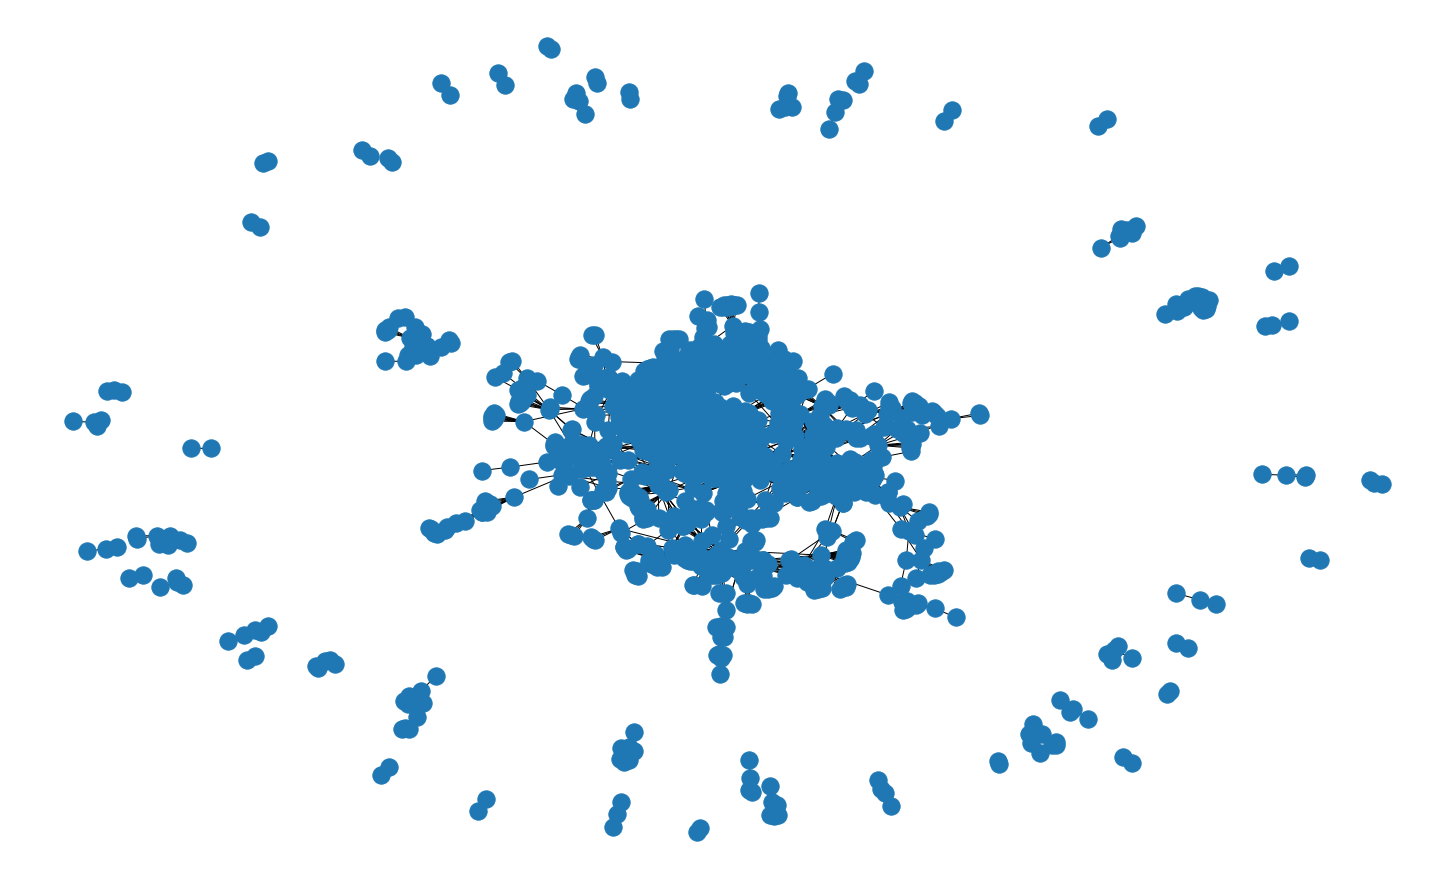

In [6]:
# Plot inferred network
plt.figure(figsize=(20,12))
nx.draw(nx_G)

In [11]:
args.prop_pos = 0.5
args.prop_neg = 0.5
args.random_seed = None

In [73]:
def generate_pos_neg_links(graph):
    """
    Select random existing edges in the graph to be postive links,
    and random non-edges to be negative links.
    Modify graph by removing the postive links.
    """
    G = copy.deepcopy(graph)
    rnd = np.random.RandomState(seed=args.random_seed)

    # Select n edges at random (positive samples)
    n_edges = G.number_of_edges()
    n_nodes = G.number_of_nodes()
    npos = int(args.prop_pos * n_edges)
    nneg = int(args.prop_neg * n_edges)

    n_nbs = [len(list(G.neighbors(v))) for v in G.nodes()]
    n_non_edges = n_nodes - 1 - np.array(n_nbs)

    non_edges = [e for e in nx.non_edges(G)]
    print("Finding %d of %d non-edges" % (nneg, len(non_edges)))

    # Select m pairs of non-edges (negative samples)
    rnd_inx = rnd.choice(len(non_edges), nneg, replace=False)
    neg_edge_list = [non_edges[ii] for ii in rnd_inx]

    if len(neg_edge_list) < nneg:
        raise RuntimeWarning(
            "Only %d negative edges found" % (len(neg_edge_list))
        )

    print("Finding %d positive edges of %d total edges" % (npos, n_edges))

    # Find positive edges, and remove them.
    edges = list(G.edges())
    pos_edge_list = []
    n_count = 0
    n_ignored_count = 0
    rnd_inx = rnd.permutation(n_edges)
    for eii in rnd_inx:
        edge = edges[eii]

        # Remove edge from graph
        data = G[edge[0]][edge[1]]
        G.remove_edge(*edge)

        pos_edge_list.append(edge)
        print("Found: %d    " % (n_count + 1), end="\r")
        n_count += 1

        # Exit if we've found npos nodes or we have gone through the whole list
        if n_count >= npos:
            break

    if len(pos_edge_list) < npos:
        raise RuntimeWarning("Only %d positive edges found." % (n_count))

    return pos_edge_list, neg_edge_list

In [74]:
pos_edge_list, neg_edge_list = generate_pos_neg_links(nx_G)

Finding 1393 of 1262059 non-edges
Finding 1393 positive edges of 2786 total edges


In [78]:
edge_functions = {
    "hadamard": lambda a, b: a * b,
    "average": lambda a, b: 0.5 * (a + b),
    "l1": lambda a, b: np.abs(a - b),
    "l2": lambda a, b: np.abs(a - b) ** 2,
}

In [79]:
def get_selected_edges(pos_edge_list, neg_edge_list):
    edges = pos_edge_list + neg_edge_list
    labels = np.zeros(len(edges))
    labels[:len(pos_edge_list)] = 1
    return edges, labels

In [86]:
def edges_to_features(edge_list, edge_function, dimensions, model):
    """
    Given a list of edge lists and a list of labels, create
    an edge feature array using binary_edge_function and
    create a label array matching the label in the list to all
    edges in the corresponding edge list
    :param edge_function:
        Function of two arguments taking the node features and returning
        an edge feature of given dimension
    :param dimension:
        Size of returned edge feature vector, if None defaults to
        node feature size.
    :param k:
        Partition number. If None use all positive & negative edges
    :return:
        feature_vec (n, dimensions), label_vec (n)
    """
    n_tot = len(edge_list)
    feature_vec = np.empty((n_tot, dimensions), dtype='f')

    # Iterate over edges
    for ii in range(n_tot):
        v1, v2 = edge_list[ii]

        # Edge-node features
        emb1 = np.asarray(model.wv[str(v1)])
        emb2 = np.asarray(model.wv[str(v2)])

        # Calculate edge feature
        feature_vec[ii] = edge_function(emb1, emb2)

    return feature_vec

In [98]:
cv_aucs = []

# Train and test graphs, with different edges
edges_train, labels_train = get_selected_edges(pos_edge_list, neg_edge_list)
edges_test, labels_test = get_selected_edges(pos_edge_list, neg_edge_list)

edge_features_train = edges_to_features(edges_train, edge_functions['hadamard'], args.dimensions, model)
edge_features_test = edges_to_features(edges_test, edge_functions['hadamard'], args.dimensions, model)

# Linear classifier
scaler = StandardScaler()
lin_clf = LogisticRegression(C=1)
clf = pipeline.make_pipeline(scaler, lin_clf)

# Train classifier
clf.fit(edge_features_train, labels_train)

predicts_train = clf.predict(edge_features_train)
auc_train = metrics.roc_auc_score(labels_train, predicts_train)

# Test classifier
predicts_test = clf.predict(edge_features_test)
auc_test = metrics.roc_auc_score(labels_test, predicts_test)

cv_aucs.append(auc_test)

print("AUC train: %.4g AUC test: %.4g"
      % (auc_train, auc_test))

AUC train: 0.9763 AUC test: 0.9763
